In [1]:
import binascii
import pandas as pd

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
FILES = range(213, 334+1)

The procedure to generate the files was following:

```bash
for d in 2018-08-{01..31} 2018-09-{01..30} 2018-10-{01..31} 2018-11-{01..30}; do
    if [ -s "$d" ]; then
        echo "$d"
        time psql.amsmetadb --no-align --tuples-only -c "with msm as (select distinct msm_no from autoclaved join report using (autoclaved_no) join measurement using (report_no) where bucket_date = '$d'), lim as (select min(msm_no), max(msm_no) from msm) select body_sha256, body_simhash, body_text_simhash, body_length from http_request where msm_no in (select * from msm) and msm_no >= (select min from lim) and msm_no <= (select max from lim) and body_sha256 is not null union all select body_sha256, body_simhash, body_text_simhash, body_length from http_control where msm_no in (select * from msm) and msm_no >= (select min from lim) and msm_no <= (select max from lim) and body_sha256 is not null" >"$d"
    fi
done

for f in 2018-*; do mv $f $(date -d "$f" +%j); done
```

In [4]:
CACHEENTRY_SIZE = int((256 + 64 + 64) / 8 / 0.268) # 26.8% is an estimate of useful space in the dict structure
MB = 1024. * 1024

The estimate was done with following `test.py` script:

```python
import binascii
import sys
import resource
import struct
import array
def load_cache():
    cache = {}
    s = struct.Struct('qq')
    with open(sys.argv[1]) as fd:
        for line in fd:
            line = line.strip().split('|')
            key = binascii.a2b_hex(line[0][2:])
            # Py2.7: 0.197, Py3.5: 0.180, Py3.6: 0.187, Py3.7: 0.187
            #value = (int(line[1]), int(line[2]))
            # Py2.7: 0.236, Py3.5: 0.223, Py3.6: 0.231, Py3.7: 0.231
            #value = line[1] + '|' + line[2]
            # Py2.7: 0.268, Py3.5: 0.268, Py3.6: 0.282, Py3.7: 0.281
            value = s.pack(int(line[1]), int(line[2]))
            # Py2.7: 0.288, Py3.5: 0.287, Py3.6: 0.303, Py3.7: 0.301
            #value = int(line[1]) << 64 | int(line[2]) # maybe that's not bit-perfect
            # Py2.7: 0.394, Py3.5: 0.396, Py3.6: 0.424, Py3.7: 0.423
            #value = None # theoretical maxium of density with dict and specific key representation
            cache[key] = value
    return cache
def main():
    base = resource.getrusage(resource.RUSAGE_SELF).ru_maxrss
    cache = load_cache()
    data = resource.getrusage(resource.RUSAGE_SELF).ru_maxrss
    rss = data - base
    print('{:d} items, {:d} KiB, {:.3f} %util'.format(len(cache), rss,
        len(cache) * ((256 + 64 + 64) / 8) / (1024. * rss)))
if __name__ == '__main__':
    main()
```

# What's the best depth?

In [5]:
def df_row_with_cache(x, cache, dyn):
    total, hit, btotal, bhit = 0, 0, 0, 0
    start_len = len(cache)
    with open('{:d}'.format(x)) as fd:
        for _ in fd:
            sz = int(_.rsplit('|', 1)[1])
            total += 1
            btotal += sz
            key = binascii.unhexlify(_[2:66])
            if key in cache:
                hit += 1
                bhit += sz
            elif dyn:
                cache.add(key)
    return (x, hit, total, bhit, btotal, start_len, len(cache))
    
def df_from_rows(row):
    d = pd.DataFrame(row, columns=['x', 'hit', 'total', 'bhit', 'btotal', 'start_len', 'end_len'])
    d['ratio'] = d.hit / d.total
    d['bratio'] = d.bhit / d.btotal
    d.set_index('x', drop=False, inplace=True)
    return d    

In [6]:
def calc(depth):
    row = []
    for x in FILES[depth:]:
        cache = set()
        for prev in xrange(depth):
            with open('{:d}'.format(x - prev - 1)) as fd:
                cache.update({binascii.unhexlify(_[2:66]) for _ in fd})
        row.append(df_row_with_cache(x, cache, dyn=False))
    return df_from_rows(row)

In [7]:
d1 = calc(depth=1)

count    119.000000
mean       0.453759
std        0.061638
min        0.000000
25%        0.452917
50%        0.461423
75%        0.468988
max        0.496665
Name: ratio, dtype: float64

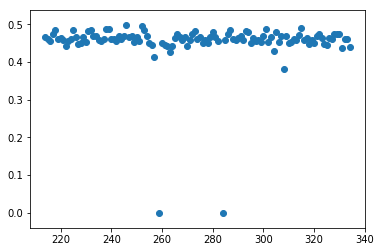

In [8]:
scatter(d1.x, d1.ratio)
d1.ratio.describe()

In [9]:
d2 = calc(depth=2)

count    118.000000
mean       0.466060
std        0.016722
min        0.387390
25%        0.457964
50%        0.466787
75%        0.475006
max        0.499960
Name: ratio, dtype: float64

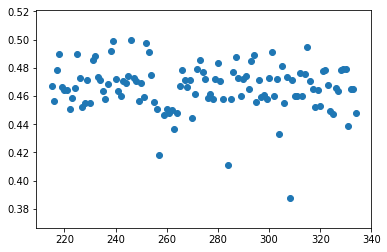

In [10]:
scatter(d2.x, d2.ratio)
d2.ratio.describe()

count    118.000000
mean       0.012398
std        0.055022
min        0.000000
25%        0.003244
50%        0.004825
75%        0.006493
max        0.446525
Name: ratio, dtype: float64

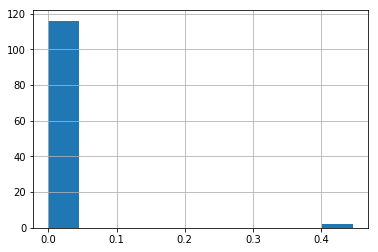

In [11]:
diff = d2.ratio - d1.ratio
diff.hist(bins=10)
diff.describe()

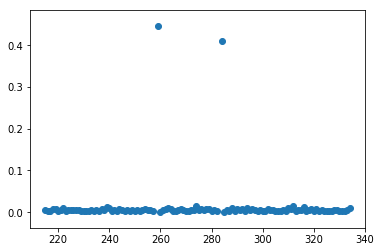

In [12]:
scatter(diff.index, diff)

So, there is no reason to take more than one bucket as Simhash cache as IQR ~ 0.003 &mdash; `depth=1` is good enough.

# Is week-old bucket as good as the yesterday's one?

In [13]:
def calc_week():
    row = []
    for x in FILES[7:]:
        with open('{:d}'.format(x - 7)) as fd:
            cache = {binascii.unhexlify(_[2:66]) for _ in fd}
        row.append(df_row_with_cache(x, cache, dyn=False))
    return df_from_rows(row)

In [14]:
d17 = calc_week()

count    113.000000
mean       0.323854
std        0.044418
min        0.000000
25%        0.323235
50%        0.329020
75%        0.335014
max        0.352001
Name: ratio, dtype: float64

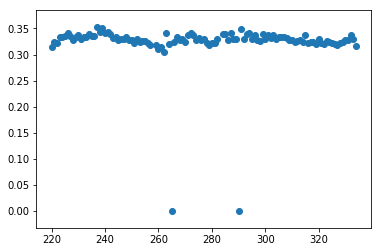

In [15]:
scatter(d17.x, d17.ratio)
d17.ratio.describe()

In [16]:
(d17.ratio - d1.ratio).describe()

count    113.000000
mean      -0.129231
std        0.077366
min       -0.463717
25%       -0.141660
50%       -0.132295
75%       -0.122428
max        0.339009
Name: ratio, dtype: float64

Yes, it's worse than fresh bucket, but that's still quite good.

# Does dynamic cache update help?

In [17]:
def calc_dyn():
    row = []
    for x in FILES[1:]:
        with open('{:d}'.format(x - 1)) as fd:
            cache = {binascii.unhexlify(_[2:66]) for _ in fd}
        row.append(df_row_with_cache(x, cache, dyn=True))
    return df_from_rows(row)        

In [18]:
dd = calc_dyn()

count    119.000000
mean       0.608656
std        0.008876
min        0.556575
25%        0.604430
50%        0.609102
75%        0.613458
max        0.626283
Name: ratio, dtype: float64

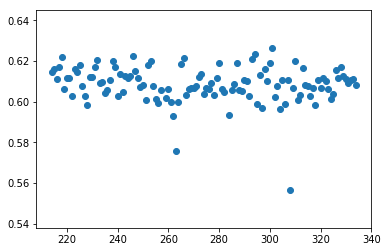

In [19]:
scatter(dd.x, dd.ratio)
dd.ratio.describe()

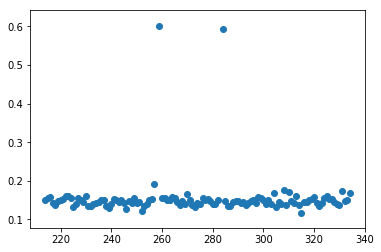

count    119.000000
mean       0.154897
std        0.059096
min        0.117732
25%        0.140775
50%        0.147136
75%        0.153087
max        0.602036
Name: ratio, dtype: float64

In [20]:
diff = dd.ratio - d1.ratio
scatter(diff.index, diff)
show()
diff.describe()

In [21]:
(dd.start_len * CACHEENTRY_SIZE / MB).describe()

count    121.000000
mean      16.120223
std        4.232953
min        0.000000
25%       14.892881
50%       15.705279
75%       16.768788
max       44.992405
Name: start_len, dtype: float64

In [22]:
(dd.end_len * CACHEENTRY_SIZE / MB).describe()

count    121.000000
mean      31.385163
std        4.862132
min       16.811636
25%       28.985656
50%       30.843297
75%       32.528865
max       58.756055
Name: end_len, dtype: float64

Doing dynamic cache update improves cache-hit from ~46% to ~60%.

# Is there easy way to reduce cache size, keeping cache-hit ratio?

In [23]:
def calc_onlydup():
    row = []
    for x in FILES[1:]:
        known, cache = set(), set()
        with open('{:d}'.format(x - 1)) as fd:
            for _ in fd:
                key = binascii.unhexlify(_[2:66])
                if key in known:
                    cache.add(key)
                known.add(key)
        row.append(df_row_with_cache(x, cache, dyn=False))
    return df_from_rows(row)

In [24]:
od = calc_onlydup()

count    119.000000
mean       0.432306
std        0.058772
min        0.000000
25%        0.432889
50%        0.439739
75%        0.446418
max        0.474412
Name: ratio, dtype: float64

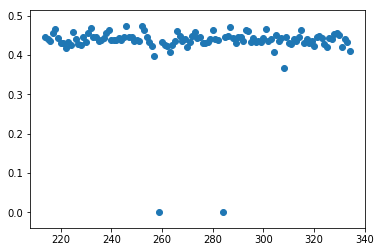

In [25]:
scatter(od.x, od.ratio)
od.ratio.describe()

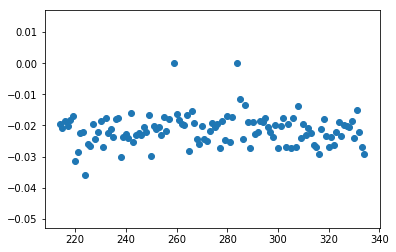

count    119.000000
mean      -0.021453
std        0.004945
min       -0.035891
25%       -0.024240
50%       -0.021191
75%       -0.018773
max        0.000000
Name: ratio, dtype: float64

In [26]:
diff = od.ratio - d1.ratio
scatter(diff.index, diff)
show()
diff.describe()

Cache-hit becomes slightly worse with "only duplicates from previous bucket" strategy: from ~46% to ~44%.

In [27]:
(od.end_len * CACHEENTRY_SIZE / MB).describe()

count    121.000000
mean       1.919296
std        0.505534
min        0.000000
25%        1.735415
50%        1.877614
75%        2.015887
max        5.161518
Name: end_len, dtype: float64

In [28]:
(d1.end_len * CACHEENTRY_SIZE / MB).describe()

count    121.000000
mean      16.120223
std        4.232953
min        0.000000
25%       14.892881
50%       15.705279
75%       16.768788
max       44.992405
Name: end_len, dtype: float64

In [29]:
((od.end_len - d1.end_len) * CACHEENTRY_SIZE / MB).describe()

count    121.000000
mean     -14.200927
std        3.758579
min      -39.830887
25%      -14.869665
50%      -13.897655
75%      -12.996148
max        0.000000
Name: end_len, dtype: float64

In [30]:
(od.end_len / d1.end_len).describe()

count    119.000000
mean       0.119339
std        0.010292
min        0.101720
25%        0.111425
50%        0.117940
75%        0.124021
max        0.150828
Name: end_len, dtype: float64

But memory savings are quite measurable! From ~16 Mib (45 max) down to ~2 MiB (5 max).

# How does _"only-dup + dynamic"_ behave?

In [31]:
def calc_combo():
    row = []
    for x in FILES[1:]:
        known, cache = set(), set()
        with open('{:d}'.format(x - 1)) as fd:
            for _ in fd:
                key = binascii.unhexlify(_[2:66])
                if key in known:
                    cache.add(key)
                known.add(key)
        row.append(df_row_with_cache(x, cache, dyn=True))
    return df_from_rows(row)

In [32]:
cc = calc_combo()

count    119.000000
mean       0.598836
std        0.008614
min        0.550029
25%        0.594257
50%        0.598882
75%        0.603401
max        0.615940
Name: ratio, dtype: float64

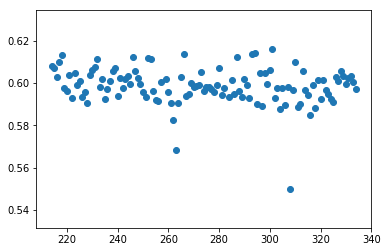

In [33]:
scatter(cc.x, cc.ratio)
cc.ratio.describe()

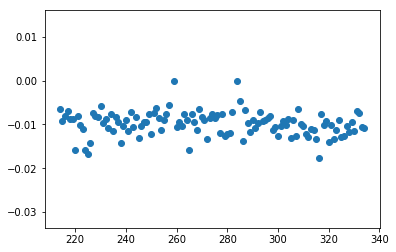

count    119.000000
mean      -0.009820
std        0.002781
min       -0.017557
25%       -0.011426
50%       -0.009475
75%       -0.008116
max        0.000000
Name: ratio, dtype: float64

In [34]:
diff = cc.ratio - dd.ratio
scatter(diff.index, diff)
show()
diff.describe()

_"Only-dup + dynamic-update"_ is ~1% worse than _"prev-bucket + dynamic-update"_.

Is memory saving measurable?...

In [35]:
print('{:.1f} -> {:.1f}'.format(dd.end_len.max() * CACHEENTRY_SIZE / MB, cc.end_len.max() * CACHEENTRY_SIZE / MB))
((cc.end_len - dd.end_len) * CACHEENTRY_SIZE / MB).describe()

58.8 -> 46.2


count    121.000000
mean     -13.828503
std        3.759391
min      -39.489471
25%      -14.576219
50%      -13.533365
75%      -12.564087
max        0.000000
Name: end_len, dtype: float64

In [36]:
(cc.end_len / dd.end_len).describe()

count    121.000000
mean       0.559057
std        0.090338
min        0.113575
25%        0.548500
50%        0.560755
75%        0.571382
max        1.000000
Name: end_len, dtype: float64

# Stats

In [37]:
def _():
    print '{:>14s} | {:>4s}   {:>4s}   {:>4s}   {:>4s}   {:>4s} | {:>4s}   {:>4s}   {:>4s}   {:>4s}   {:>4s}'.format(
        'name',
        'hit0', 'h25', 'h50', 'h75', 'h100',
        'mem0', 'm25', 'm50', 'm75', 'm100'
    )
    
    for name, stat in (
        ('d1-gap7', d17),
        ('only-dup', od),
        ('d1', d1),
        ('d2', d2),
        ('only-dup + dyn', cc),
        ('d1 + dyn', dd),
    ):
        r = stat.ratio.describe()
        m = stat.end_len.describe() * CACHEENTRY_SIZE / MB
        
        print '{:>14s} | {:>4.1f}   {:>4.1f}   {:>4.1f}   {:>4.1f}   {:>4.1f} | {:>4.1f}   {:>4.1f}   {:>4.1f}   {:>4.1f}   {:>4.1f}'.format(
            name,
            r['min'] * 100, r['25%'] * 100, r['50%'] * 100, r['75%'] * 100, r['max'] * 100,
            m['min'], m['25%'], m['50%'], m['75%'], m['max']
        )
_()

          name | hit0    h25    h50    h75   h100 | mem0    m25    m50    m75   m100
       d1-gap7 |  0.0   32.3   32.9   33.5   35.2 |  0.0   14.8   15.7   16.7   45.0
      only-dup |  0.0   43.3   44.0   44.6   47.4 |  0.0    1.7    1.9    2.0    5.2
            d1 |  0.0   45.3   46.1   46.9   49.7 |  0.0   14.9   15.7   16.8   45.0
            d2 | 38.7   45.8   46.7   47.5   50.0 | 16.8   29.0   30.8   32.6   58.8
only-dup + dyn | 55.0   59.4   59.9   60.3   61.6 |  2.2   16.3   17.2   18.2   46.2
      d1 + dyn | 55.7   60.4   60.9   61.3   62.6 | 16.8   29.0   30.8   32.5   58.8


# Why is speedup so small if hit-rate is so good?!

Something like ~15% speedup with ~50% hit-rate on a test set... Or ~33% speedup with ~60% hit-rate full bucket.

Seems, CPU is spent on "bytes", not not "pages", so we should count hit-rate in bytes...

In [38]:
def _():
    print '{:>14s} | {:>4s}   {:>4s}   {:>4s}   {:>4s}   {:>4s} | {:>4s}   {:>4s}   {:>4s}   {:>4s}   {:>4s}'.format(
        'name',
        'hit0', 'h25', 'h50', 'h75', 'h100',
        'mem0', 'm25', 'm50', 'm75', 'm100'
    )
    
    for name, stat in (
        ('d1-gap7', d17),
        ('only-dup', od),
        ('d1', d1),
        ('d2', d2),
        ('only-dup + dyn', cc),
        ('d1 + dyn', dd),
    ):
        r = stat.bratio.describe()
        m = stat.end_len.describe() * CACHEENTRY_SIZE / MB
        
        print '{:>14s} | {:>4.1f}   {:>4.1f}   {:>4.1f}   {:>4.1f}   {:>4.1f} | {:>4.1f}   {:>4.1f}   {:>4.1f}   {:>4.1f}   {:>4.1f}'.format(
            name,
            r['min'] * 100, r['25%'] * 100, r['50%'] * 100, r['75%'] * 100, r['max'] * 100,
            m['min'], m['25%'], m['50%'], m['75%'], m['max']
        )
_()

          name | hit0    h25    h50    h75   h100 | mem0    m25    m50    m75   m100
       d1-gap7 |  0.0    6.4    6.7    7.0    8.5 |  0.0   14.8   15.7   16.7   45.0
      only-dup |  0.0   17.2   17.9   18.7   21.0 |  0.0    1.7    1.9    2.0    5.2
            d1 |  0.0   19.0   19.7   20.8   23.1 |  0.0   14.9   15.7   16.8   45.0
            d2 | 12.4   19.4   20.1   21.2   23.3 | 16.8   29.0   30.8   32.6   58.8
only-dup + dyn | 29.8   36.8   37.4   38.2   41.2 |  2.2   16.3   17.2   18.2   46.2
      d1 + dyn | 30.4   37.5   38.2   39.0   42.0 | 16.8   29.0   30.8   32.5   58.8
